

| EDA dataframe      | Description |due|
| ----------- | ----------- |----------- |
| grape_df  | 캠벨얼리 가격/거래량 + 소비자 물가 지수 + 자동차용경유 + 날씨(4개-평균기온, 평균온량, 일강수량, 일교차) + 수출입(4개) + 재배면적 + 샤인머스켓 거래량 + 실업률_경제활동인구(2개-경제활동인구, 실업률) + 최저시급    |20190101 ~ 20201104|
| shinemuscat_df   |샤인마스캇  가격/거래량 + 소비자 물가 지수 + 자동차용경유 + 날씨(4개-평균기온, 평균온량, 일강수량, 일교차) + 수출입(4개) + 재배면적 + 블루베리 거래량 + 실업률_경제활동인구(2개-경제활동인구, 실업률) + 최저시급        |20190101 ~ 20201104|
| df      | grape_train + shinemuscat_train       | 20190101 ~ 2020928|


**train accuracy / test accuracy 의 차이 비교 overfitting = 20% 이상 (10~20%)**

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'

from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl
from IPython.core.display import display, HTML
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import urllib.request
import requests
import json
import datetime
import os
from datetime import datetime
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

/var/folders/08/yfq1rzmx605_pllcn65f77540000gn/T/ipykernel_16387/2031877544.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# iMACA
# raw_path = '/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/products_price_predict/data/raw/'
# processed_path = '/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/products_price_predict/data/processed/'

In [2]:
# Macbook
raw_path = '/Users/goeun/Documents/YearDream/ProJect/kurly_project/products_price_predict/data/raw/'
processed_path = '/Users/goeun/Documents/YearDream/ProJect/kurly_project/products_price_predict/data/processed/'

In [7]:
train = pd.read_csv(raw_path+'train.csv')
test = pd.read_csv(raw_path+'test.csv')
private = pd.read_csv(raw_path+'private_data.csv')
submission = pd.read_csv(raw_path+'sample_submission.csv')


print(train.shape)
print(test.shape)
print(private.shape)
print(submission.shape)

(1770, 9)
(1770, 9)
(1733, 44)
(37, 44)
(291, 44)
(228, 22)


# LGBM(LightGBM)

## 캠벨얼리
성능을 알아보기 위한 모델 <br> 캠벨얼리 가격을 예측
[lightgbm](https://tpwkcorqhd.tistory.com/32)

In [4]:
df = pd.concat([train,test]).reset_index(drop=True)
grape_df = df[['date','캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)' ]]
shinemuscat_df = df[['date', '샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)']]

In [26]:
df[df['date'] == "2020-08-31"] # :1705
# valid df|[1705:1733] 
df[df['date'] == "2020-09-28"] # 1733:

date   요일  배추_거래량(kg)  배추_가격(원/kg)  무_거래량(kg)  무_가격(원/kg)  \
1732  2020-09-28  월요일   2405051.9       1867.0  2747519.5      1147.0   

      양파_거래량(kg)  양파_가격(원/kg)  건고추_거래량(kg)  건고추_가격(원/kg)  ...  청상추_거래량(kg)  \
1732   2235784.7        964.0       1630.6       22022.0  ...      84155.0   

      청상추_가격(원/kg)  백다다기_거래량(kg)  백다다기_가격(원/kg)  애호박_거래량(kg)  애호박_가격(원/kg)  \
1732        4167.0      554862.6         2873.0     667745.0        2782.0   

      캠벨얼리_거래량(kg)  캠벨얼리_가격(원/kg)  샤인마스캇_거래량(kg)  샤인마스캇_가격(원/kg)  
1732      601841.0         3761.0       382263.4         10998.0  

[1 rows x 44 columns]

In [42]:
# train 20190101 ~ 20200831 / valid   20200901 ~ 20200928 / test 20200929 ~ 20201104

train_split = 1705
valid_split = 1733

feature = df[['캠벨얼리_거래량(kg)','샤인마스캇_거래량(kg)']]
target = df['캠벨얼리_가격(원/kg)']

X_train = feature[:train_split]
y_train = target[:train_split]

X_valid = feature[train_split:valid_split]
y_valid = target[train_split:valid_split]

X_test = feature[valid_split:]
y_test = target[valid_split:]

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,X_test.shape, y_test.shape)

(1705, 2) (1705,) (28, 2) (28,) (37, 2) (37,)


### LightGBM
```
params = {'learning_rate': 0.01, 
          'max_depth': 6, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 100, 
          'feature_fraction': 0.8, 
          'bagging_fraction': 0.8, 
          'bagging_freq': 5, 
          'seed':42,
          'num_threads':8
             }
```

In [43]:
import lightgbm as lgb

def init_score(y):
    return y - np.mean(y)

In [38]:
train_ds = lgb.Dataset(X_train,  label = y_train)
val_ds = lgb.Dataset(X_valid,  label = y_valid)

In [44]:
params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, 
                   train_ds,
                   1000,
                   val_ds,
                   verbose_eval = 100, 
                   early_stopping_rounds = 100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1705, number of used features: 2
[LightGBM] [Info] Start training from score 3210.956598
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 805.752
Early stopping, best iteration is:
[1]	valid_0's l1: 679.603


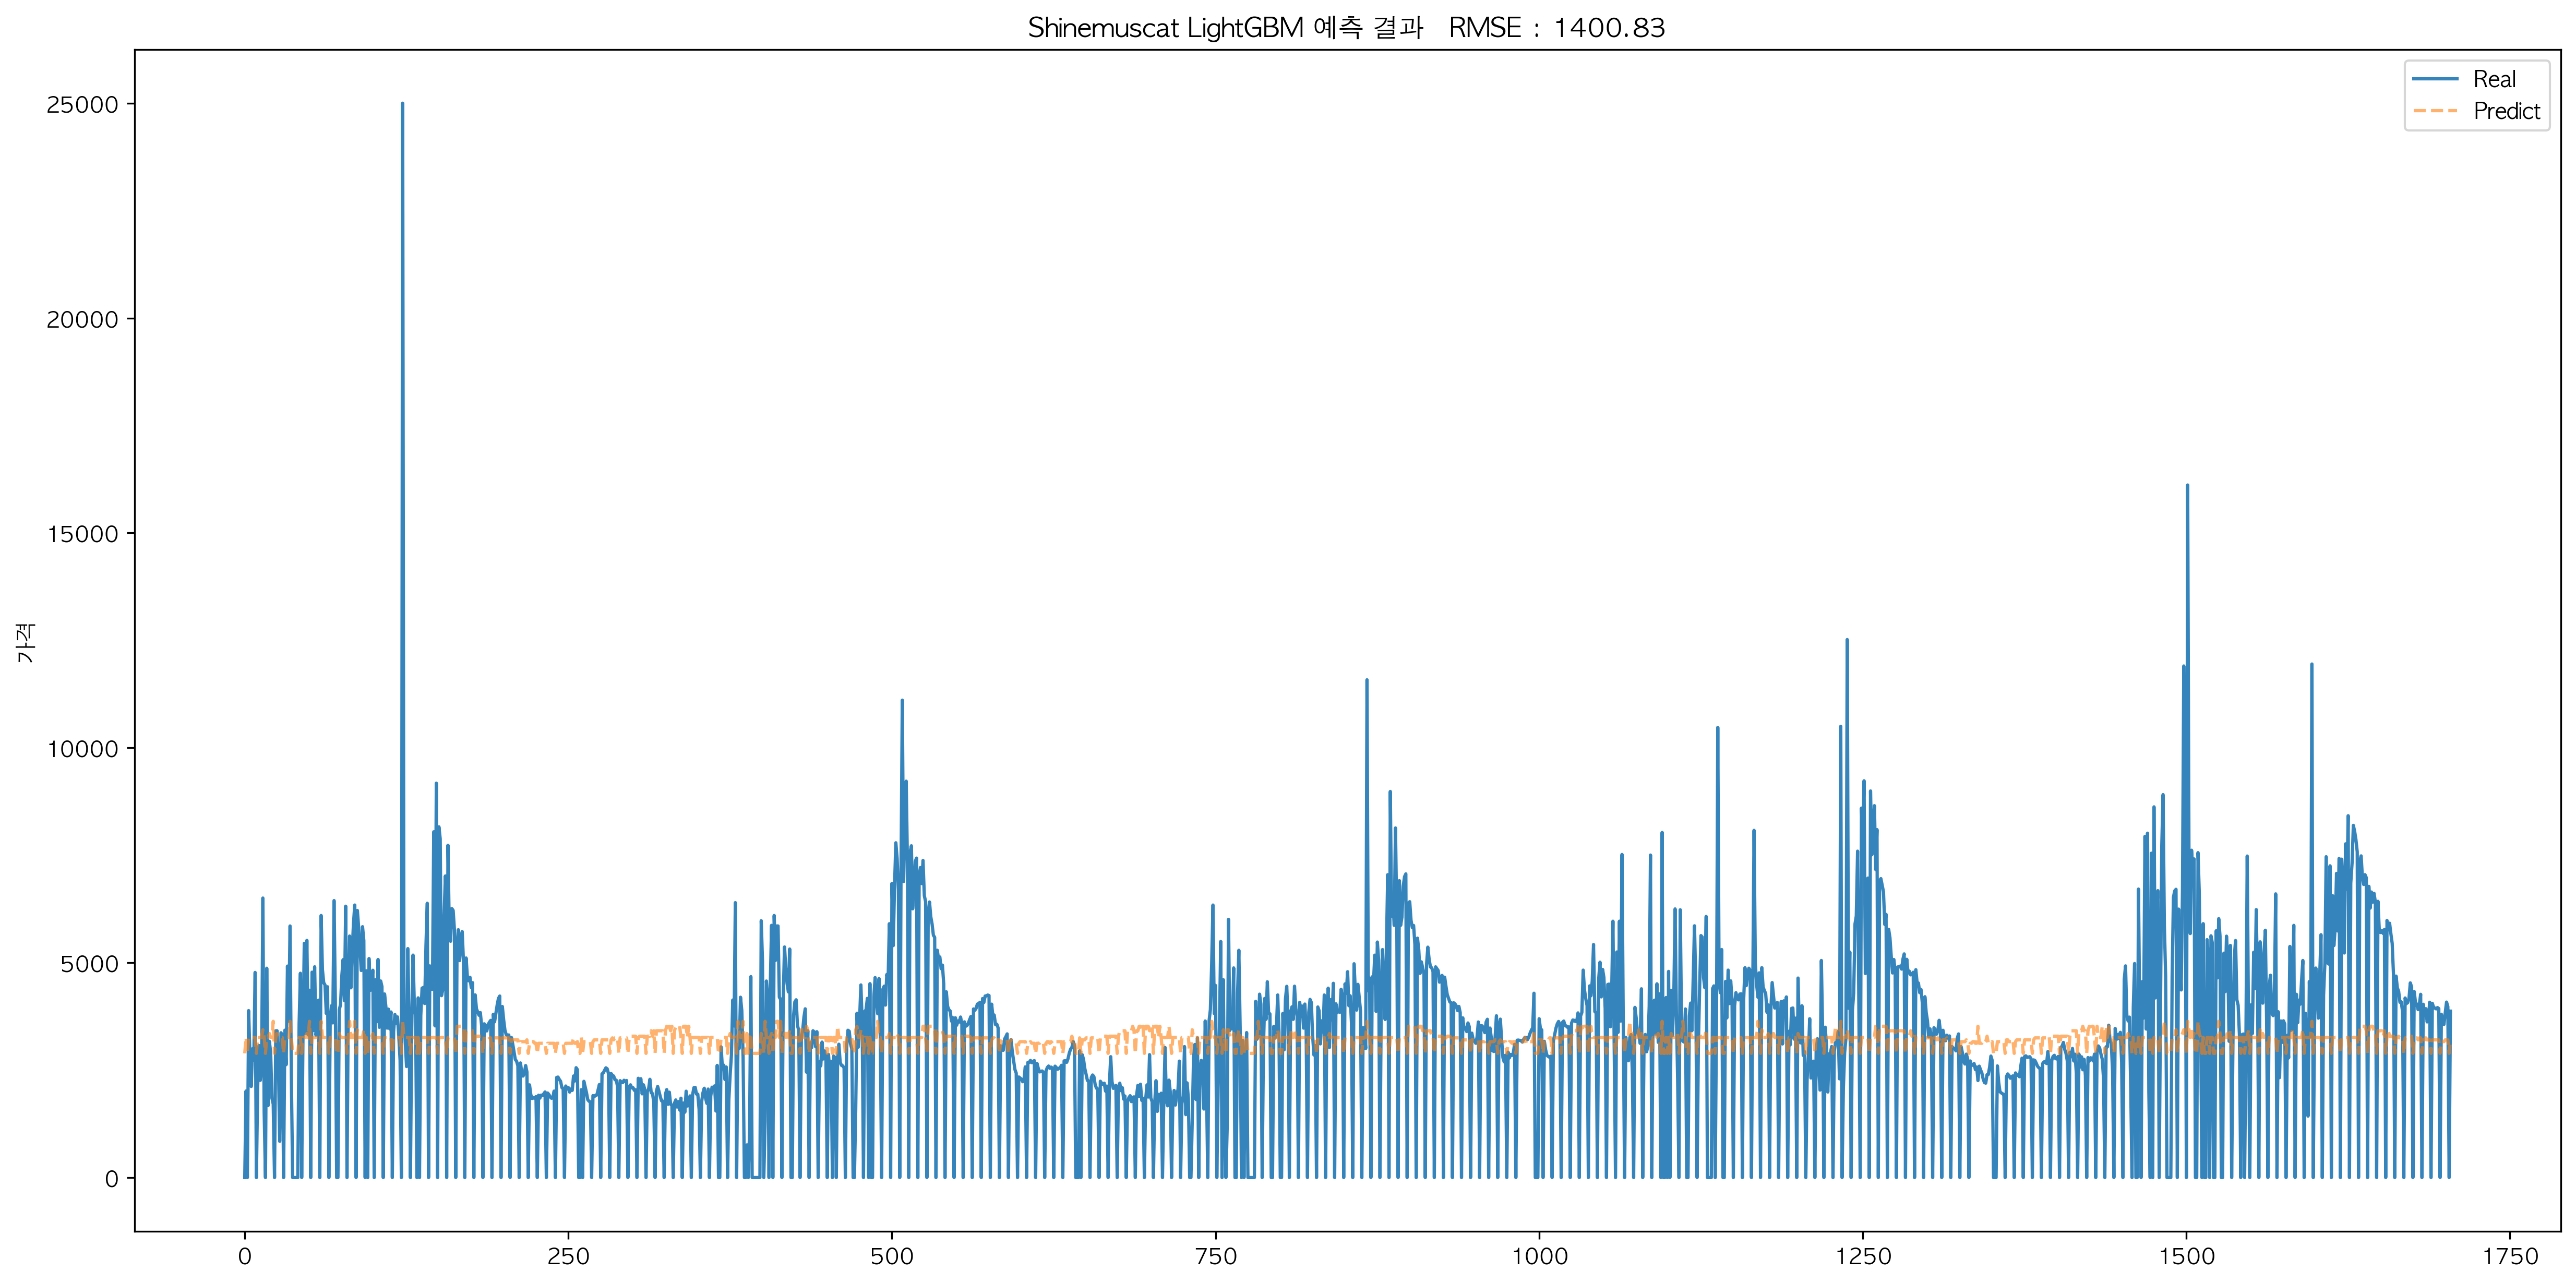

In [45]:
# metrics
y_pred = model.predict(X_test)
RMSE = (mean_squared_error(y_test, y_pred) ** 0.5)
# np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 10), dpi=300)
plt.title('grape LightGBM 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

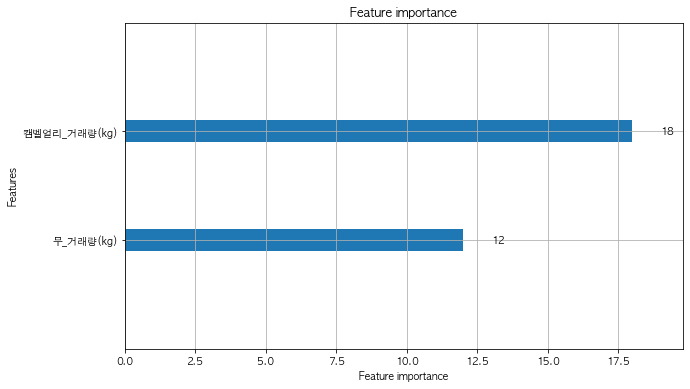

In [59]:
# importance
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize = (10,6))
plot_importance(model, ax = ax)

In [48]:
## 모델 검증(accuracy_score)

print(f'X_train accuracy_score : {model.score(X_train, y_train)}')
print(f'X_test accuracy_score : {model.score(X_valid, y_valid)}')

AttributeError: 'Booster' object has no attribute 'score'

In [54]:
## 모델 예측

x_test = np.array([[370000, 20000]])### 모델의 예측 결과
전반적인 추세는 잘 예측하지만 거래가 발생하지 않는 일요일 전후로 예측 성능이 떨어지는 모습을 보임

큰 폭으로 변동되는 가격은 잘 예측 하지 못함(뾰족뾰족한 부분)

[모델링참고](https://github.com/seongmoonKang/Data-Analysis-Capstone)

label = y_pred[0]
y_predict = model.predict(x_test)
confidence = y_predict[0]

print(f'label : {label} \nconfidence : {confidence}\nratio : {round(label/confidence, 2)}' )

label : 3162.41146506738 
confidence : 3204.372049525749
ratio : 0.99


### 모델의 예측 결과
전반적인 추세는 잘 예측하지만 거래가 발생하지 않는 일요일 전후로 예측 성능이 떨어지는 모습을 보임

큰 폭으로 변동되는 가격은 잘 예측 하지 못함(뾰족뾰족한 부분)

[모델링참고](https://github.com/seongmoonKang/Data-Analysis-Capstone)

## 2. 샤인마스캇

In [61]:
# train 20190101 ~ 20200831 / valid   20200901 ~ 20200928 / test 20200929 ~ 20201104

train_split = 1705
valid_split = 1733

feature = df[['샤인마스캇_거래량(kg)','캠벨얼리_거래량(kg)']]
target = df['샤인마스캇_가격(원/kg)']

X_train = feature[:train_split]
y_train = target[:train_split]

X_valid = feature[train_split:valid_split]
y_valid = target[train_split:valid_split]

X_test = feature[valid_split:]
y_test = target[valid_split:]

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,X_test.shape, y_test.shape)

(1705, 2) (1705,) (28, 2) (28,) (37, 2) (37,)


In [63]:
import lightgbm as lgb

def init_score(y):
    return y - np.mean(y)

In [64]:
train_ds = lgb.Dataset(X_train,  label = y_train)
val_ds = lgb.Dataset(X_valid,  label = y_valid)

In [65]:
params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, 
                   train_ds,
                   1000,
                   val_ds,
                   verbose_eval = 100, 
                   early_stopping_rounds = 100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1705, number of used features: 2
[LightGBM] [Info] Start training from score 6930.746628
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 771.919
Early stopping, best iteration is:
[80]	valid_0's l1: 757.528


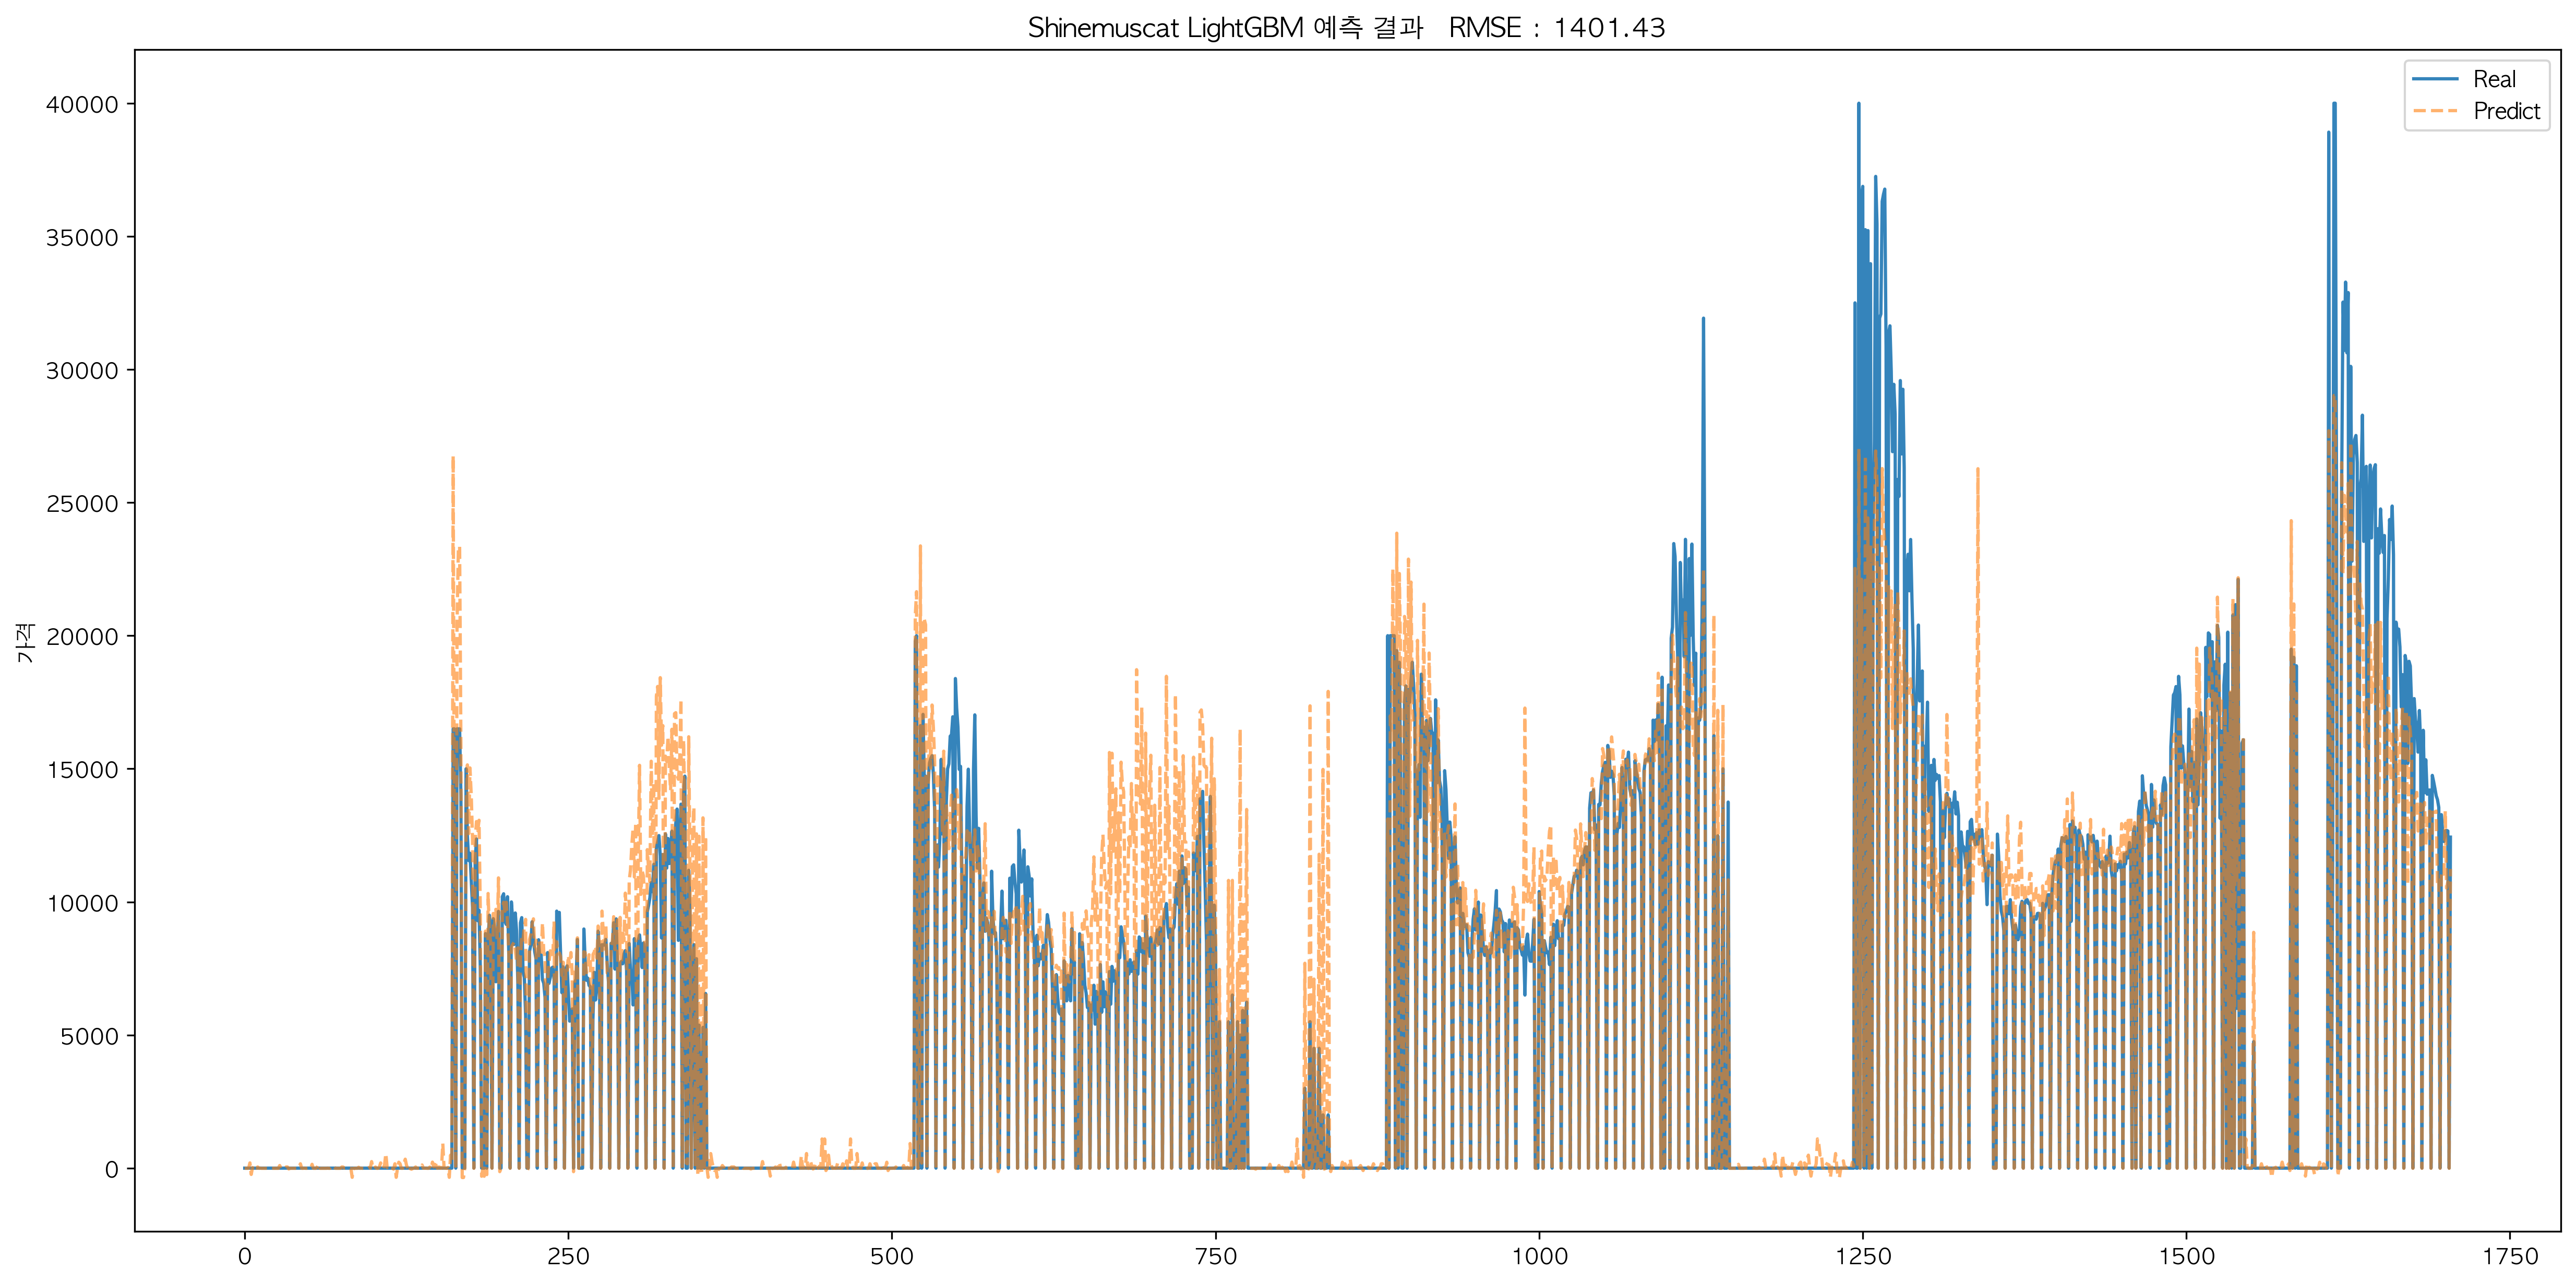

In [66]:
# metrics
y_pred = model.predict(X_test)
RMSE = (mean_squared_error(y_test, y_pred) ** 0.5)
# np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 10), dpi=300)
plt.title('Shinemuscat LightGBM 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

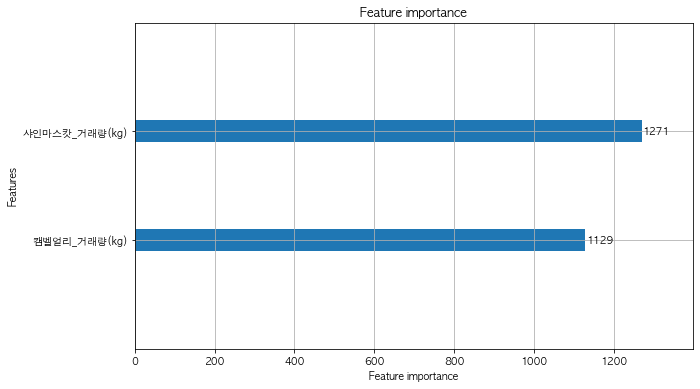

In [67]:
# importance
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize = (10,6))
plot_importance(model, ax = ax)

In [68]:
## 모델 검증(accuracy_score)

print(f'X_train accuracy_score : {model.score(X_train, y_train)}')
print(f'X_test accuracy_score : {model.score(X_valid, y_valid)}')

AttributeError: 'Booster' object has no attribute 'score'

In [70]:
## 모델 예측

x_test = np.array([[20000, 3000]])

label = y_pred[0]
y_predict = model.predict(x_test)
confidence = y_predict[0]

print(f'label : {label} \nconfidence : {confidence}\nratio : {round(label/confidence, 2)}' )

label : 11012.849781997134 
confidence : 12882.826371035666
ratio : 0.85


# LSTM
## 캠벨얼리


In [32]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose, STL

train_split = 1705
valid_split = 1733

feature = ['캠벨얼리_거래량(kg)']
target = grape_df[['캠벨얼리_가격(원/kg)']]

X_train = df[feature][:train_split].values.reshape(-1,1,len(feature))
y_train = target[:train_split].values.reshape(-1,1,1)

X_valid = df[feature][train_split:valid_split].values.reshape(-1,1,len(feature))
y_valid = target[train_split:valid_split].values.reshape(-1,1,1)

X_test = df[feature][valid_split:].values.reshape(-1,1,len(feature))
y_test = target[valid_split:].values.reshape(-1,1,1)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,X_test.shape, y_test.shape)

(1705, 1, 1) (1705, 1, 1) (28, 1, 1) (28, 1, 1) (37, 1, 1) (37, 1, 1)


In [33]:
model = Sequential()
model.add(layers.Activation('relu'))
model.add(tf.compat.v1.keras.layers.LSTM(100, input_shape=(21,len(feature)), return_sequences=True))
model.add(Dropout(0.1))
model.add(layers.Dense(30))
model.add(Dropout(0.1))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(patience=30)
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split = 0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/1000
48/48 [==============================] - 1s 4ms/step - loss: 14071373.0000 - val_loss: 22855706.0000
Epoch 2/1000
48/48 [==============================] - 0s 2ms/step - loss: 13981902.0000 - val_loss: 22694654.0000
Epoch 3/1000
48/48 [==============================] - 0s 2ms/step - loss: 13821234.0000 - val_loss: 22417182.0000
Epoch 4/1000
48/48 [==============================] - 0s 2ms/step - loss: 13554103.0000 - val_loss: 21920292.0000
Epoch 5/1000
48/48 [==============================] - 0s 2ms/step - loss: 13020472.0000 - val_loss: 20962340.0000
Epoch 6/1000
48/48 [==============================] - 0s 2ms/step - loss: 12202853.0000 - val_loss: 19571670.0000
Epoch 7/1000
48/48 [==============================] - 0s 2ms/step - loss: 11150154.0000 - val_loss: 17996880.0000
Epoch 8/1000
48/48 [==============================] - 0s 2ms/step - loss: 10010202.0000 - val_loss: 16363939.0000
Epoch 9/1000
48/48 [==============================] - 0s 2ms/step - loss: 8882694.0000 -

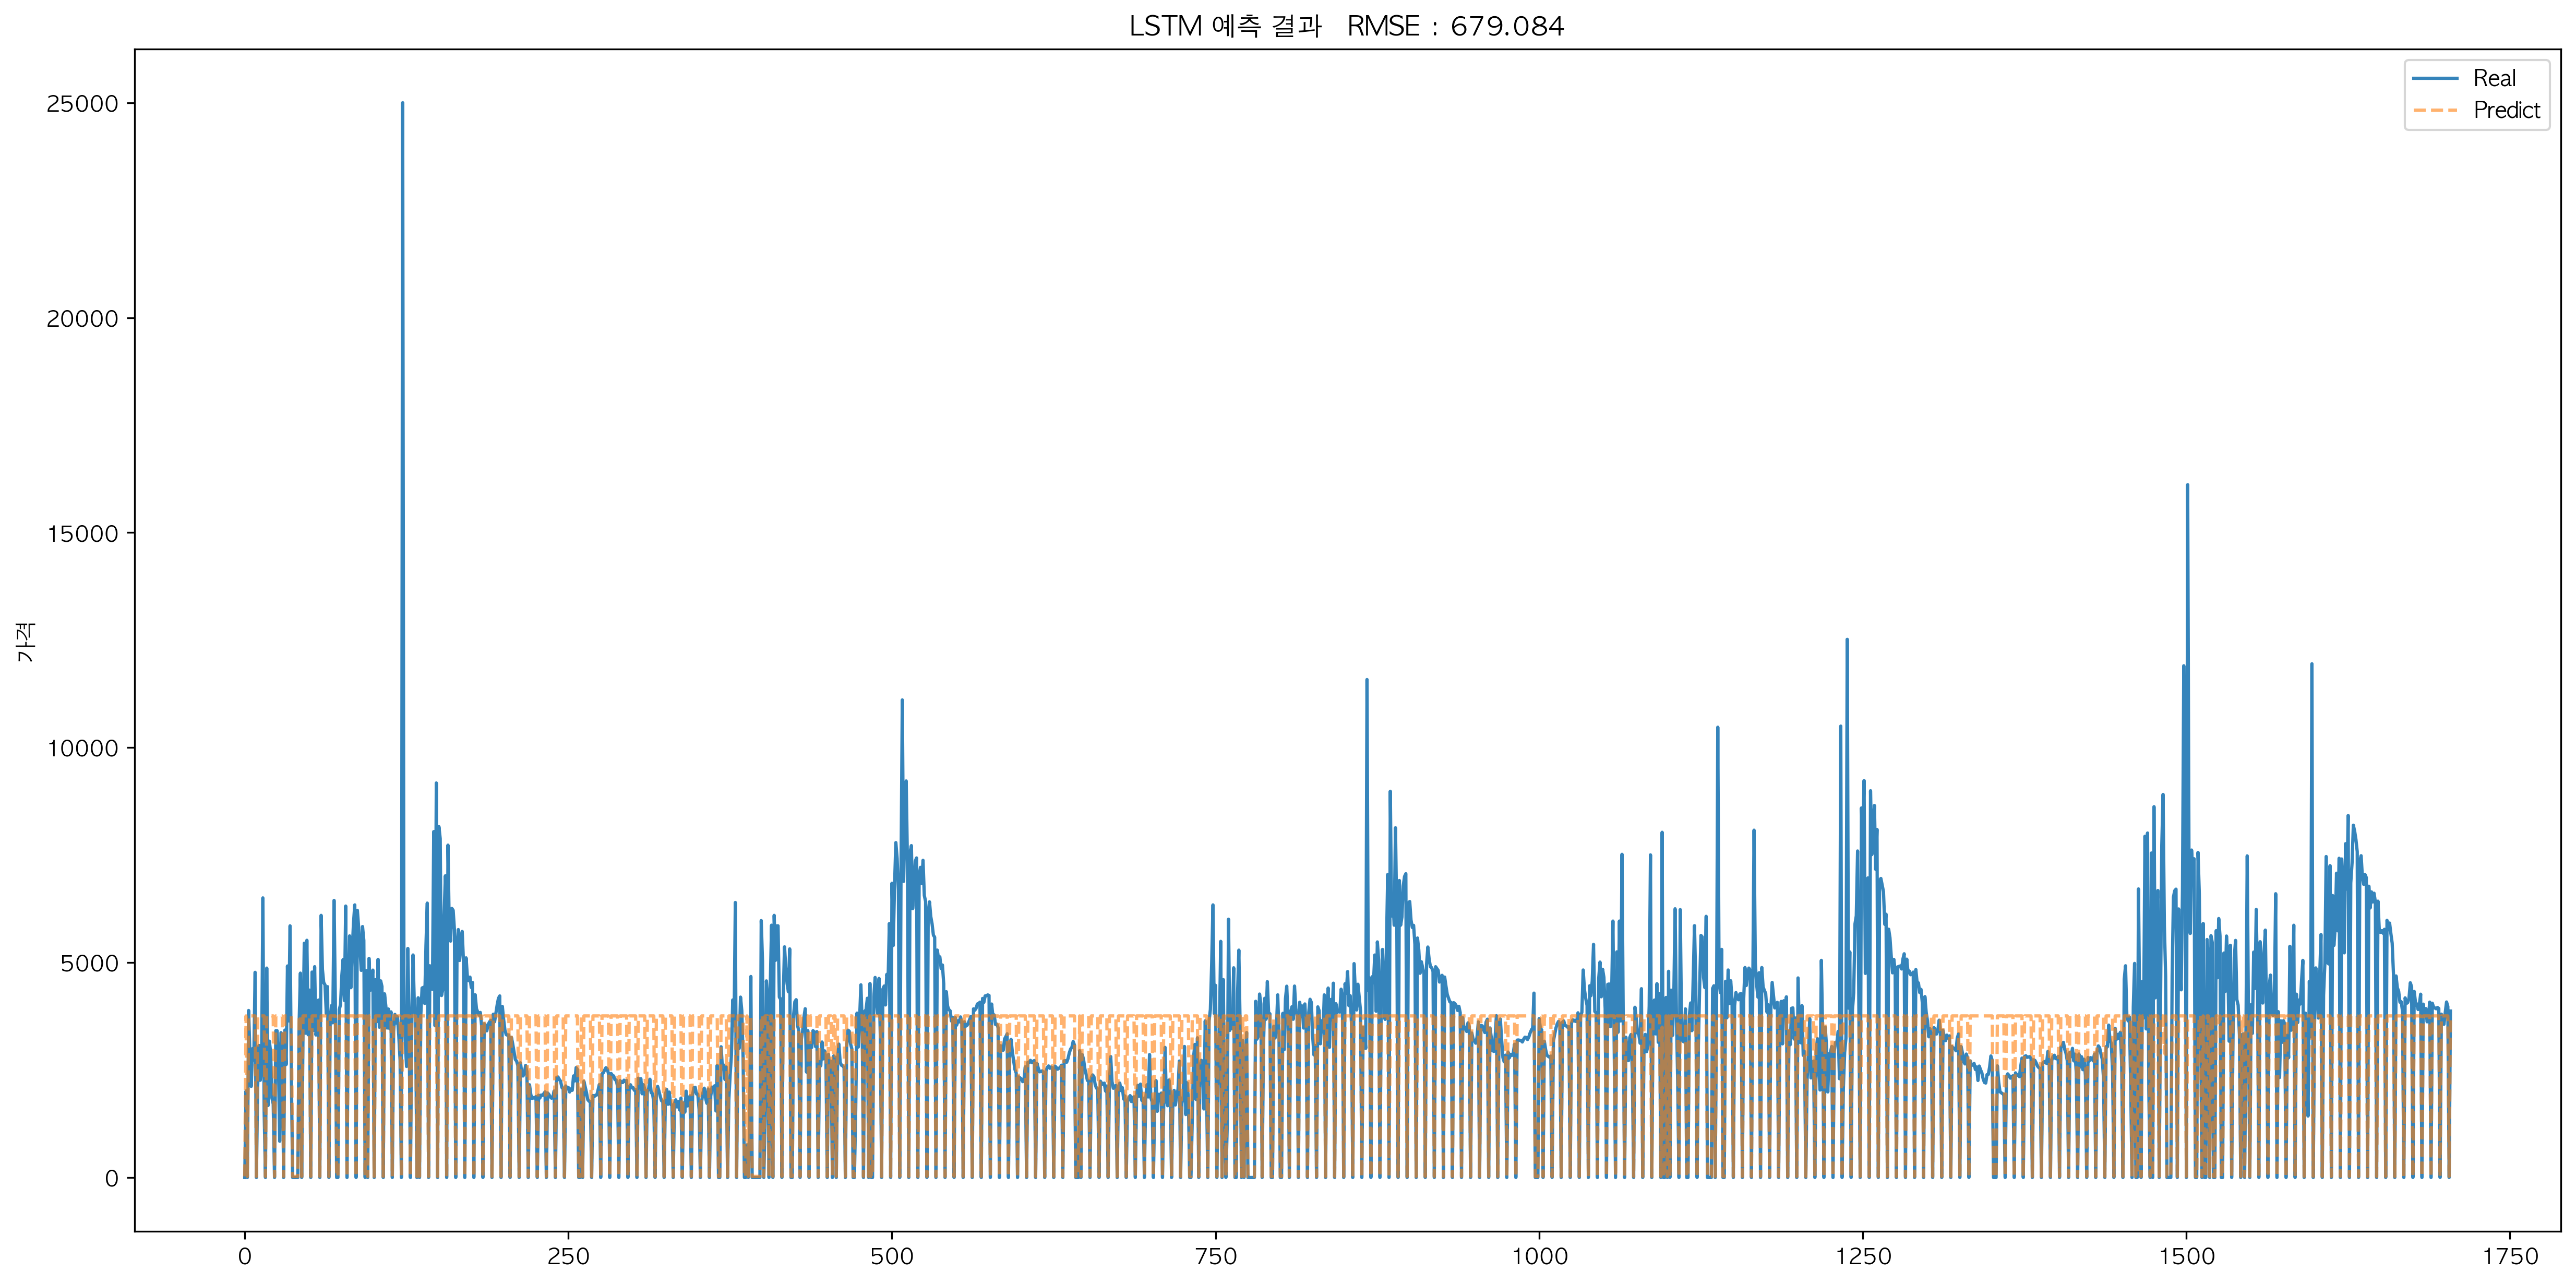

In [34]:
y_pred = model.predict(X_test)
RMSE = mean_squared_error(y_test.reshape(-1,1), y_pred.reshape(-1,1)) ** 0.5

plt.figure(figsize=(20, 10), dpi=300)
plt.title('LSTM 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train.reshape(-1,1)), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train).reshape(-1,1), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()


## 샤인머스켓

In [29]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose, STL

train_split = 1705
valid_split = 1733

feature = ['샤인마스캇_거래량(kg)']
target = shinemuscat_df[['샤인마스캇_가격(원/kg)']]

X_train = df[feature][:train_split].values.reshape(-1,1,len(feature))
y_train = target[:train_split].values.reshape(-1,1,1)

X_valid = df[feature][train_split:valid_split].values.reshape(-1,1,len(feature))
y_valid = target[train_split:valid_split].values.reshape(-1,1,1)

X_test = df[feature][valid_split:].values.reshape(-1,1,len(feature))
y_test = target[valid_split:].values.reshape(-1,1,1)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,X_test.shape, y_test.shape)

(1705, 1, 1) (1705, 1, 1) (28, 1, 1) (28, 1, 1) (37, 1, 1) (37, 1, 1)


In [30]:
model = Sequential()
model.add(layers.Activation('relu'))
model.add(tf.compat.v1.keras.layers.LSTM(100, input_shape=(21,len(feature)), return_sequences=True))
model.add(Dropout(0.1))
model.add(layers.Dense(30))
model.add(Dropout(0.1))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(patience=30)
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split = 0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/1000
48/48 [==============================] - 1s 7ms/step - loss: 95572104.0000 - val_loss: 253043328.0000
Epoch 2/1000
48/48 [==============================] - 0s 2ms/step - loss: 95437352.0000 - val_loss: 252694320.0000
Epoch 3/1000
48/48 [==============================] - 0s 2ms/step - loss: 95099048.0000 - val_loss: 251832784.0000
Epoch 4/1000
48/48 [==============================] - 0s 2ms/step - loss: 94312768.0000 - val_loss: 249981712.0000
Epoch 5/1000
48/48 [==============================] - 0s 2ms/step - loss: 92859912.0000 - val_loss: 247115824.0000
Epoch 6/1000
48/48 [==============================] - 0s 2ms/step - loss: 90975192.0000 - val_loss: 243650816.0000
Epoch 7/1000
48/48 [==============================] - 0s 2ms/step - loss: 88608744.0000 - val_loss: 239376224.0000
Epoch 8/1000
48/48 [==============================] - 0s 2ms/step - loss: 86015224.0000 - val_loss: 234634352.0000
Epoch 9/1000
48/48 [==============================] - 0s 2ms/step - loss: 830548

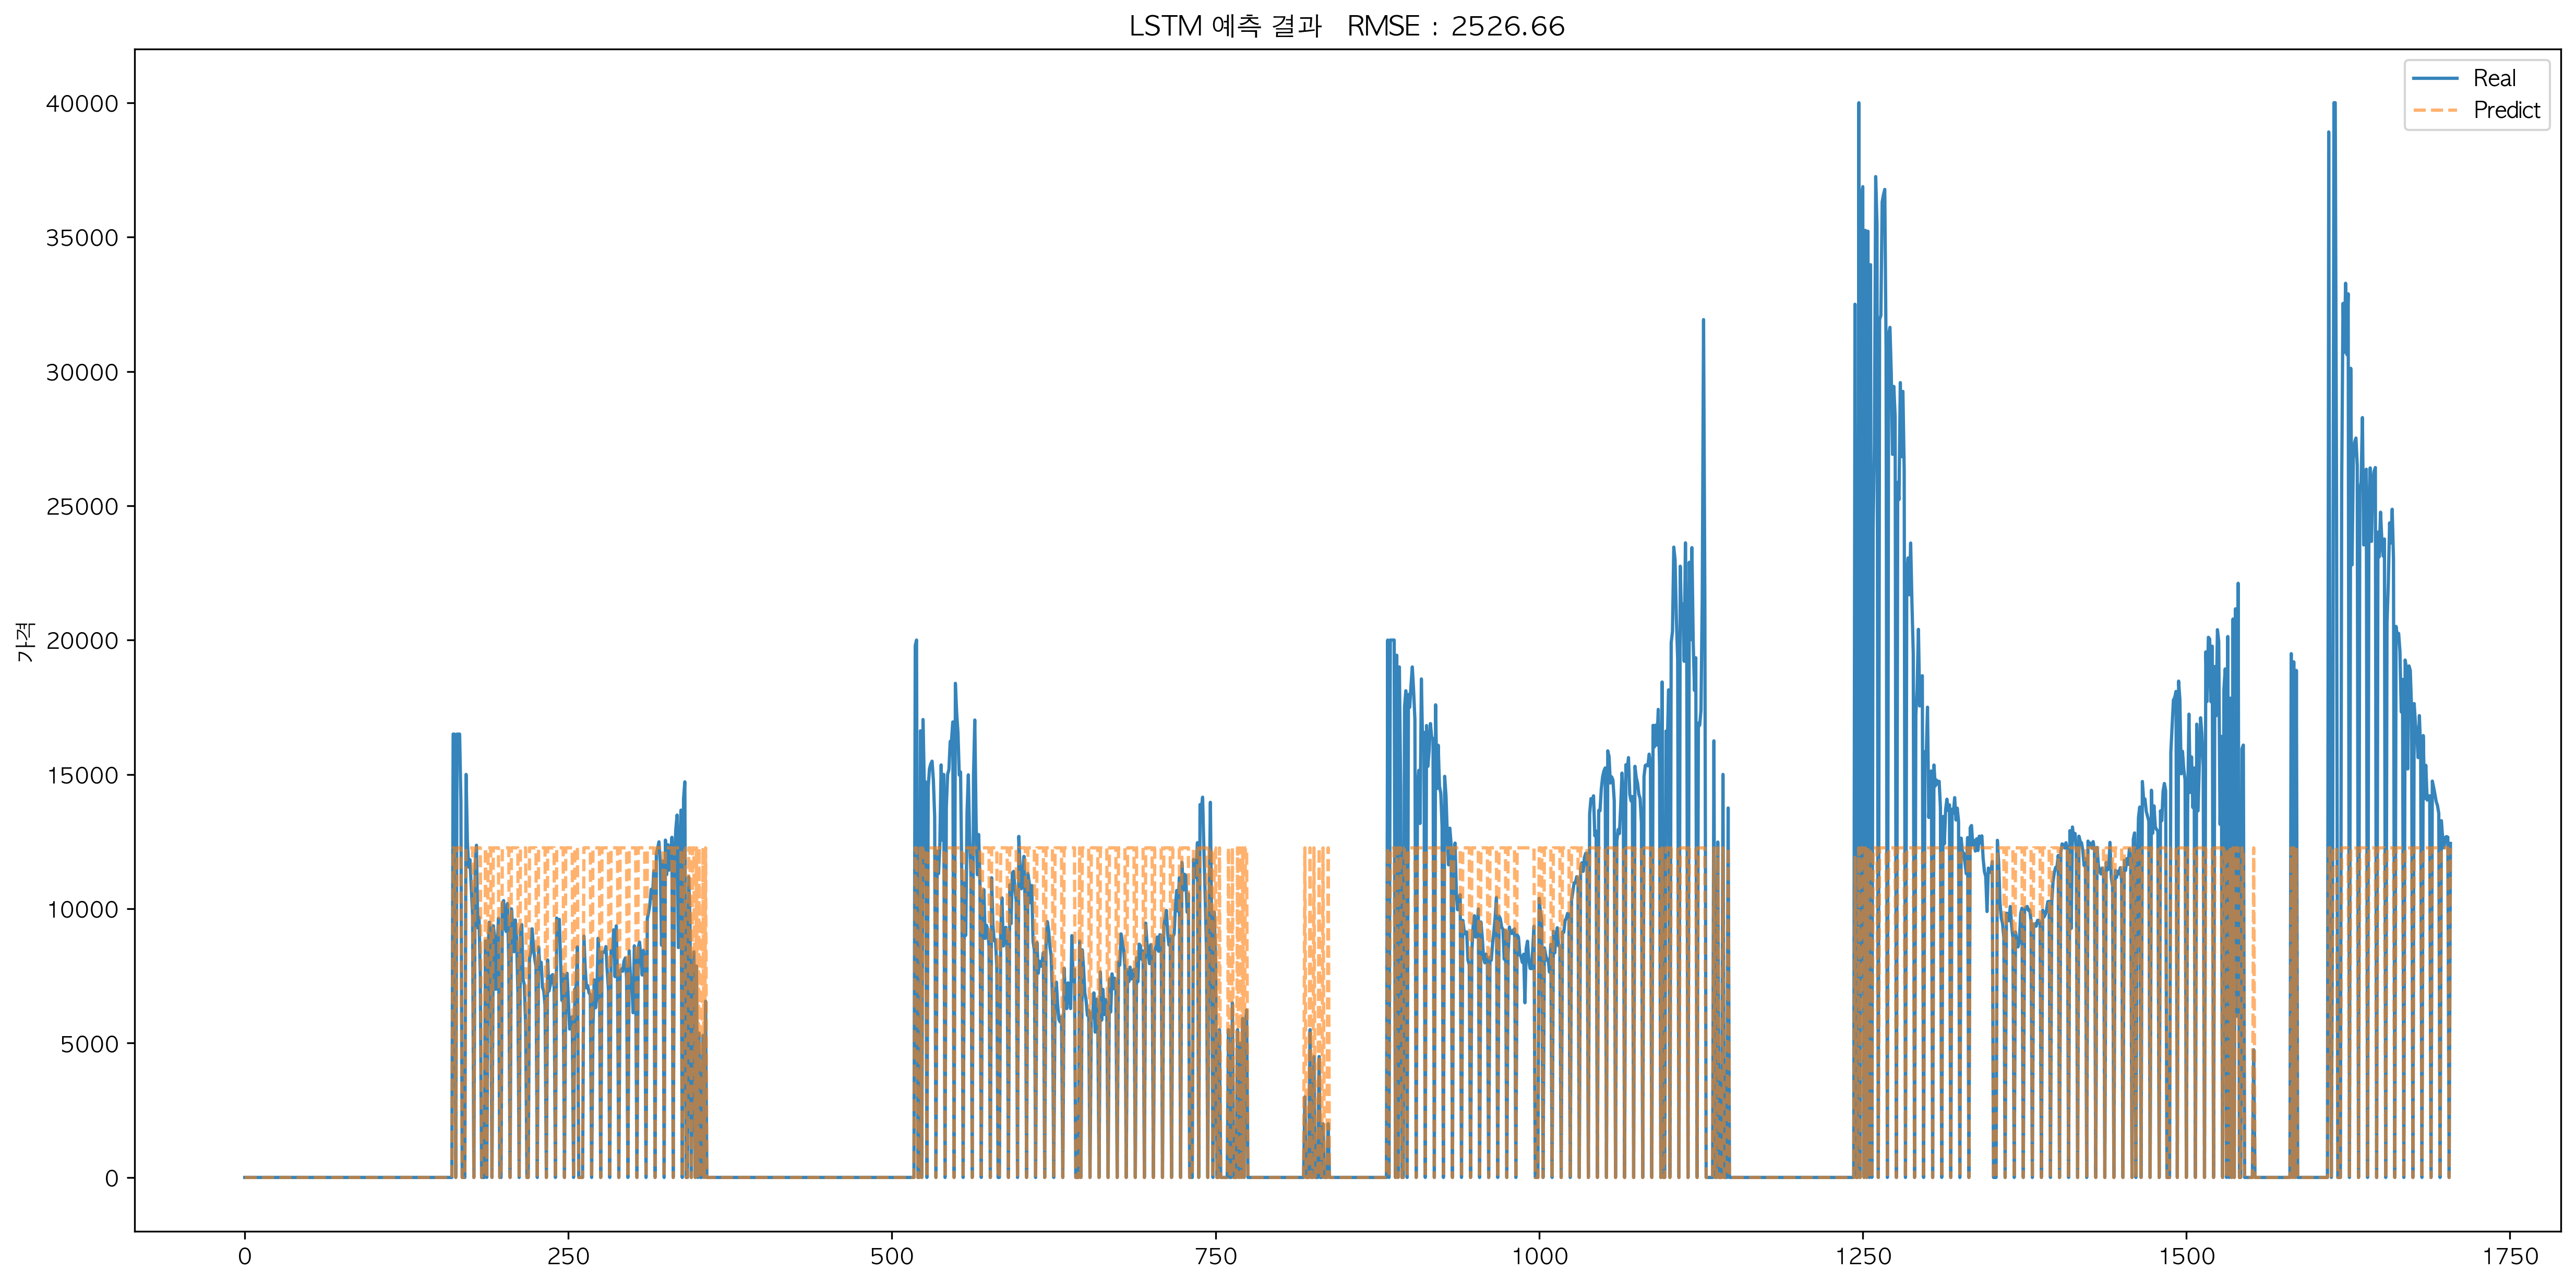

In [31]:
y_pred = model.predict(X_test)
RMSE = mean_squared_error(y_test.reshape(-1,1), y_pred.reshape(-1,1)) ** 0.5

plt.figure(figsize=(20, 10), dpi=300)
plt.title('LSTM 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train.reshape(-1,1)), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train).reshape(-1,1), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()